<h1 align="center"><font size="8"> scVelo Analysis </font></h1>

> Huitian (Yolanda) Diao, Sept. 14 2020 <br>
> Source: [Velocyto notebook](https://github.com/velocyto-team/velocyto-notebooks.git)


- vlm object:
    - Gene IDs: vlm.ra['Gene']
    - Cell IDs: vlm.ca['CellID']

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import copy
import sys
from importlib import reload
from pathlib import Path

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2020-11-08 20:25.


In [2]:
code_dir = os.getcwd()
base_dir = code_dir.replace("/codes_local","")
parent_dir = "/".join(base_dir.split("/")[:-1])
tools_dir = parent_dir + "/tools"

sys.path.insert(1, tools_dir)
import sc_addons
reload(sc_addons)

sp_name = base_dir.split("/")[-1]
analysis_name = ["2", "actWT_Dyn"]

wk_dir = base_dir + "/2_scVelo/%s-%s_scVelo_out"%(analysis_name[0],analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name, analysis_name)

1_IL2RAKO ['2', 'actWT_Dyn']


## 0. Read input

In [3]:
adata = scv.read(base_dir + '/2_scVelo/0-all_scVelo_out/1_IL2RAKO_scVelo_preNN.h5ad')
adata = adata[adata.obs['cell_type'] != 'P14NAV']
adata = adata[adata.obs['cell_type'] != "CD25KO"]

In [4]:
scv.pp.moments(adata, n_pcs=20, n_neighbors=20)
scv.pp.neighbors(adata, n_pcs=20, n_neighbors=20)

scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)

computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [5]:
#adata.uns['louvain_colors'] = ['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
#                               '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78'] # P4, P5, P6, P7

Renamed 'paga' to convention 'X_paga' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_paga', embedded velocity vectors (adata.obsm)


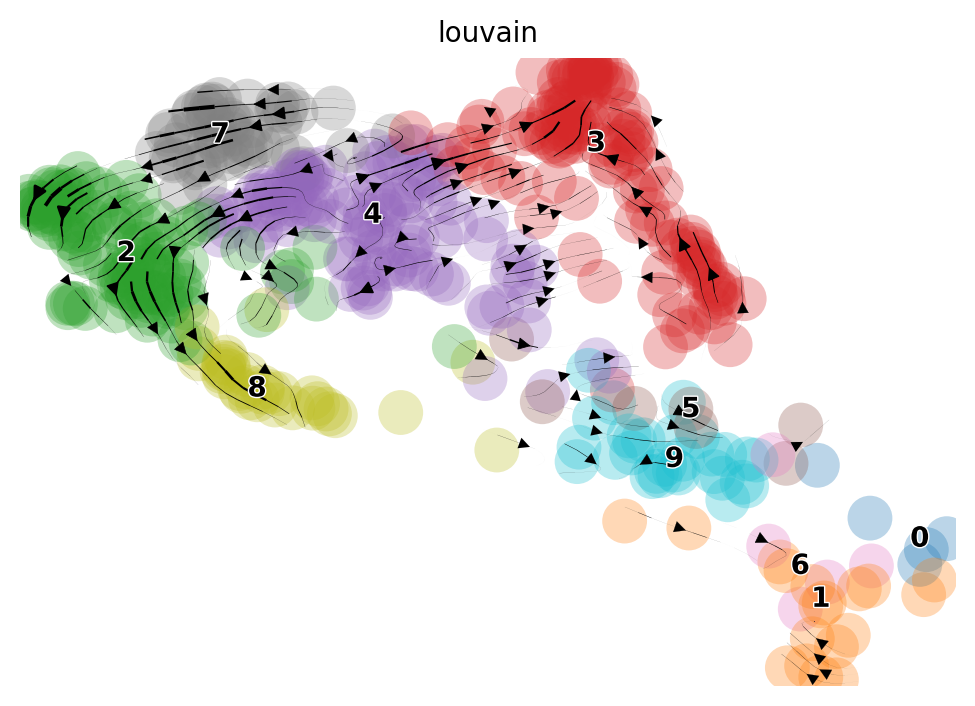

In [6]:
scv.pl.velocity_embedding_stream(adata, basis='paga', color=['louvain'], dpi=100)

In [7]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

recovering dynamics
    finished (0:00:56) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
adata.write('%s_scVelo.h5ad'%sp_name, compression='gzip')
adata.write_csvs("scVelo")

writing .csv files to scVelo


-----

## Reload point

In [9]:
adata = scv.read('%s_scVelo.h5ad'%sp_name)

In [10]:
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='louvain', minimum_spanning_tree=False, use_time_prior=False)
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA 
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0.065,0.15,0,0,0,0,0,0,0.67,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0.32,0.4,0,0.058,0,0,0,0.31
5,0.12,0.31,0,0,0,0,0.12,0,0,0
6,0.11,0.21,0,0,0,0,0,0,0,0
7,0,0,0.51,0.3,0.29,0,0,0,0,0
8,0,0.076,0,0,0,0,0,0,0,0
9,0,0,0,0.33,0,0,0,0,0,0


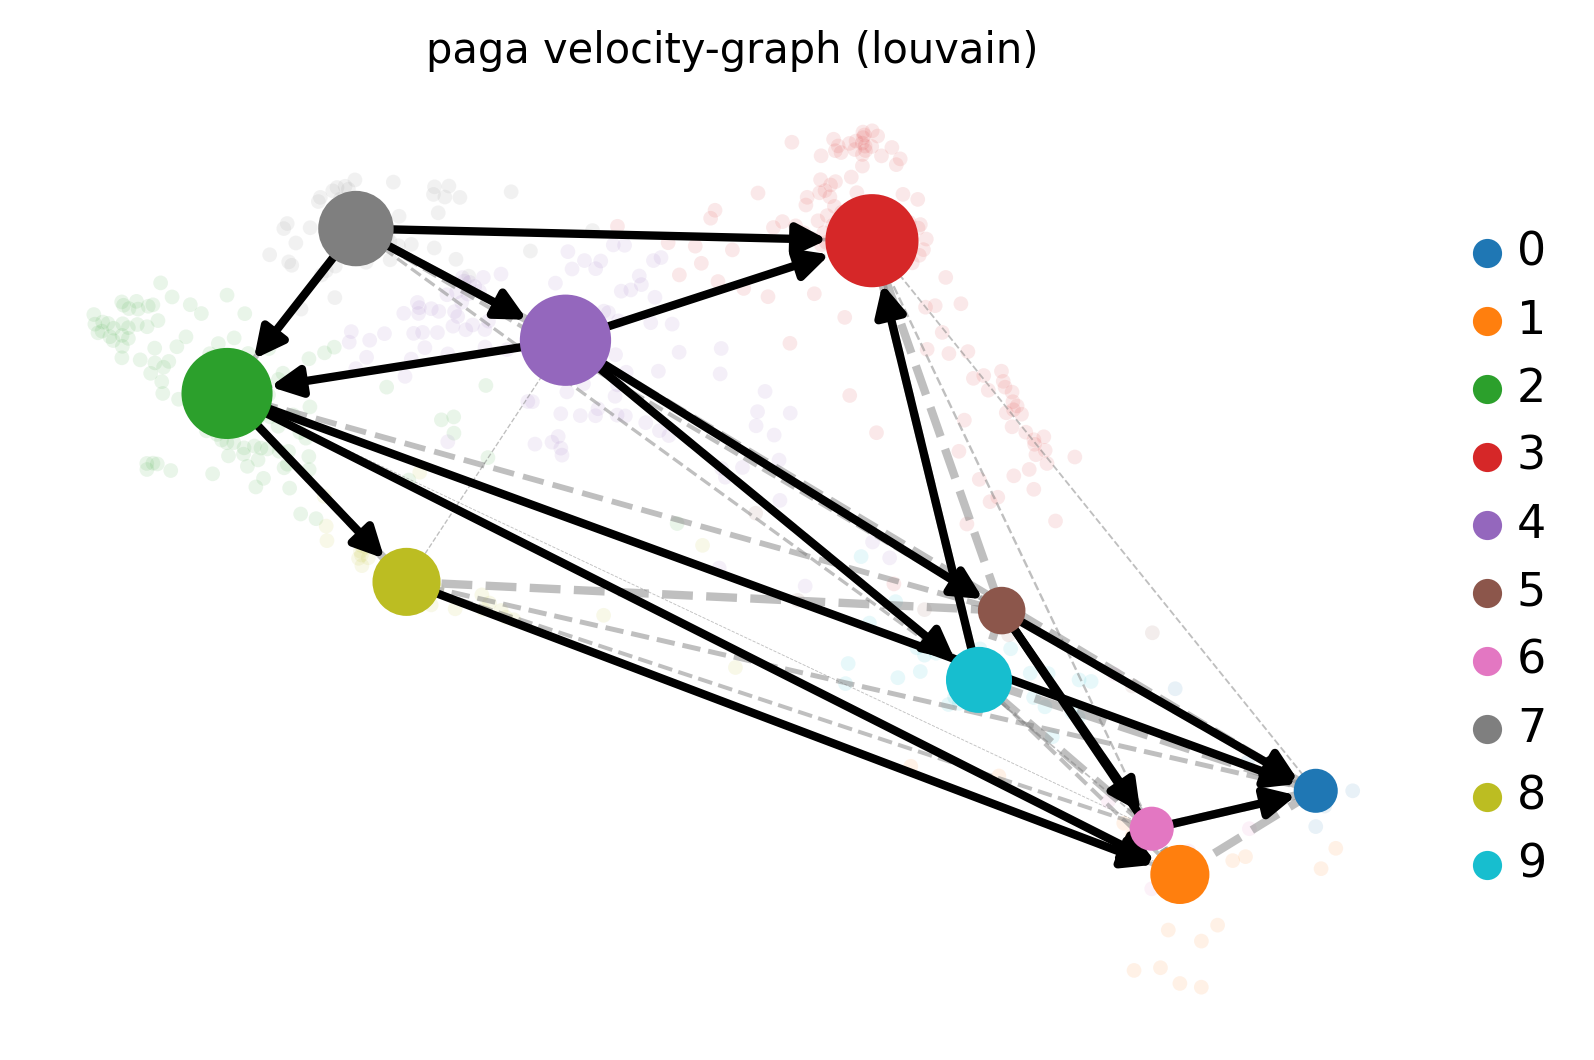

In [11]:
scv.pl.paga(adata, basis='paga', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, dpi=150)